<a href="https://colab.research.google.com/github/flowergum/Colorization/blob/main/My_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, \
                                    Dense, \
                                    MaxPool2D,\
                                    Dropout, \
                                    Flatten, \
                                    BatchNormalization, InputLayer, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from skimage.color import rgb2lab, lab2rgb
import tensorflow as tf
from skimage.io import imsave
import numpy as np
from google.colab import files
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def processed_image(img):
  image = img.resize( (128, 128))               # нужный нам размер
  image = np.array(image, dtype=float)          # в массив
  size = image.shape                            # размер изображения
  lab = rgb2lab(1.0/255*image)                  #  в лаб, предварительно переведя в диапазон от 0 до 1
  X, Y = lab[:,:,0], lab[:,:,1:]                #в Х кладем яркостную компоненту, в Y -- две цветовые

  Y /= 128                                      # нормируем выходные значение в диапазон от -1 до 1
  X = X.reshape(1, size[0], size[1], 1)
  Y = Y.reshape(1, size[0], size[1], 2)
  return X, Y, size

In [4]:
def pr_img():
    x_train = np.zeros((10, 128, 128, 1))       # тут создаем пакеты
    y_train = np.zeros((10, 128, 128, 2))
    for i in range(10):
        name = 'drive/MyDrive/Colorization/Step_2.Flowers/easy_geometry/' + str(i+1) + '.jpg'
        img = Image.open(name)
        x_train[i], y_train[i], size = processed_image(img)
    return x_train, y_train


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2652 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128) ,  (128, 128) ,  (128, 128)
(128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


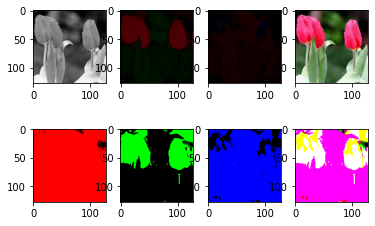

In [5]:
img = Image.open('drive/MyDrive/Colorization/Step_2.Flowers/test/6.jpg')   # тут проверяем, что пространство норм 
image = img.resize( (128, 128))              
image = np.array(image, dtype=float)         
size = image.shape                           
lab = rgb2lab(1.0/255*image)                 
X, Y, Z = lab[:,:,0], lab[:,:,1], lab[:,:,2] 
A = np.zeros((128, 128))                                 
#X = X.reshape(1, size[0], size[1], 1)
#Y = Y.reshape(1, size[0], size[1], 1)
#Z = Z.reshape(1, size[0], size[1], 1)
print(X.shape, ', ', Y.shape, ', ', Z.shape)
X1 = np.stack((X, A, A), axis=2)
Y1 = np.stack((A, Y, A), axis=2)
Z1 = np.stack((A, A, Z), axis=2)
A1 = np.stack((X, Y, Z), axis=2)
print(X1.shape)
plt.subplot(2, 4, 1)
plt.imshow(lab2rgb(X1))
plt.subplot(2, 4, 2)
plt.imshow(lab2rgb(Y1))
plt.subplot(2, 4, 3)
plt.imshow(lab2rgb(Z1))
plt.subplot(2, 4, 4)
plt.imshow(lab2rgb(A1))
#Как я поняла, дальше он сам решает, что ему дали только зеленый канал или только красный, оэтому получаются странные результаты
plt.subplot(2, 4, 5)
plt.imshow((X1))
plt.subplot(2, 4, 6)
plt.imshow((Y1))
plt.subplot(2, 4, 7)
plt.imshow((Z1))
plt.subplot(2, 4, 8)
plt.imshow((A1))

In [6]:
x_train, y_train = pr_img()             

In [7]:
model = Sequential()                                                      # Последовательная
model.add(InputLayer(input_shape=(None, None, 1)))                        # Входной слой, подаем на вход яркостную компоненту
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))          # Свертка, 64 фильтра
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2))) #Растягивает картинку
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [8]:
model2 = Sequential()     #из статьи сравниваю
model2.add(InputLayer(input_shape=(None, None, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(UpSampling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(UpSampling2D((2, 2)))
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model2.add(UpSampling2D((2, 2)))

model2.compile(optimizer='adam', loss='mse')

In [9]:
model2.fit(x=x_train, y=y_train, batch_size=10, epochs=100)

Epoch 1/100
1/1 [==============================] - 19s 19s/step - loss: 0.1390
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 0.7653
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 0.2456
Epoch 4/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0350
Epoch 5/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0344
Epoch 6/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0339
Epoch 7/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0373
Epoch 8/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0337
Epoch 9/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0338
Epoch 10/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0342
Epoch 11/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0336
Epoch 12/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0337
Epoch 13/100
1/1 [==============================]

In [10]:
model.compile(optimizer='adam', loss='mse')

In [11]:
model.fit(x=x_train, y=y_train, batch_size=10, epochs=100)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6156
Epoch 2/100
1/1 [==============================] - 0s 55ms/step - loss: 1.0467
Epoch 3/100
1/1 [==============================] - 0s 58ms/step - loss: 0.7742
Epoch 4/100
1/1 [==============================] - 0s 58ms/step - loss: 1.0617
Epoch 5/100
1/1 [==============================] - 0s 57ms/step - loss: 1.0617
Epoch 6/100
1/1 [==============================] - 0s 58ms/step - loss: 1.0618
Epoch 7/100
1/1 [==============================] - 0s 57ms/step - loss: 1.0620
Epoch 8/100
1/1 [==============================] - 0s 58ms/step - loss: 1.0608
Epoch 9/100
1/1 [==============================] - 0s 57ms/step - loss: 1.0612
Epoch 10/100
1/1 [==============================] - 0s 56ms/step - loss: 1.0631
Epoch 11/100
1/1 [==============================] - 0s 58ms/step - loss: 1.0631
Epoch 12/100
1/1 [==============================] - 0s 56ms/step - loss: 1.0616
Epoch 13/100
1/1 [==============================] -

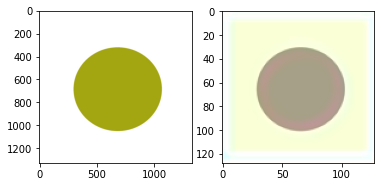

In [12]:
img = Image.open('drive/MyDrive/Colorization/Step_2.Flowers/easy_geometry/12.jpg')
X, Y, size = processed_image(img)

output = model.predict(X)

output *= 128
min_vals, max_vals = -128, 127
ab = np.clip(output[0], min_vals, max_vals)

cur = np.zeros((size[0], size[1], 3))
cur[:,:,0] = np.clip(X[0][:,:,0], 0, 100)
cur[:,:,1:] = ab
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(lab2rgb(cur))